## FB15k-237 semantic graph

https://www.kaggle.com/datasets/latebloomer/fb15k-237/data

https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping

In [48]:
# !pip install kagglehub

In [49]:
# import kagglehub

# path = kagglehub.dataset_download("latebloomer/fb15k-237")
# print("Path to dataset files:", path)

In [52]:
import pandas as pd
import numpy as np

In [171]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
data_path = "../datasets/fb15k-237/"

### Load triples and augment from source

### Load augmented triples directly

In [54]:
relations_df = pd.read_csv(f"{data_path}/derived/relations_with_ids.csv")

In [55]:
relations_df.head()

,relation_name,relation_id
0,/location/country/form_of_government,0
1,/tv/tv_program/regular_cast./tv/regular_tv_app...,1
2,/media_common/netflix_genre/titles,2
3,/award/award_winner/awards_won./award/award_ho...,3
4,/soccer/football_team/current_roster./sports/s...,4


In [56]:
# freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.tsv", sep='\t')

freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/derived/fb_wiki_mapping_incl_wiki_extracts.csv")

In [57]:
# freebase_vs_wiki_df[''] = df.index
freebase_vs_wiki_df.head(3)

,freebase_id,wikidata_id,label,Title,Extract
0,/m/010016,Q128306,Denton,"Denton, Texas",Denton is a city in the U.S. state of Texas an...
1,/m/0100mt,Q16562,El Paso,"El Paso, Texas",El Paso is a city in and the county seat of El...
2,/m/0102t4,Q52996,Marshall,"Marshall, Texas",Marshall is a city in the U.S. state of Texas....


In [84]:
freebase_vs_wiki_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13756 entries, 0 to 13755
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   freebase_id  13756 non-null  object
 1   label        13756 non-null  object
 2   Title        13756 non-null  object
 3   Extract      13756 non-null  object
 4   wikidata_id  13756 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 537.5+ KB


In [59]:
# strip Q from wikidata id for easier use with Kumo AI
freebase_vs_wiki_df['wikidata_int_id'] = freebase_vs_wiki_df.apply(lambda row: int(row['wikidata_id'][1:]), axis=1)

freebase_vs_wiki_df.drop('wikidata_id', axis=1, inplace=True)
freebase_vs_wiki_df.rename(columns={'wikidata_int_id':'wikidata_id'}, inplace=True)

In [60]:
triplets_with_src_dst_wiki_ids_df = pd.read_csv(f"{data_path}/exp4/triplets_with_src_dst_wiki_extracts.csv.gz")

In [62]:
df_test = pd.read_csv(f"{data_path}/exp4/triplets_with_src_dst_wiki_extracts.test.csv.gz")

In [63]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17940 entries, 0 to 17939
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             17940 non-null  int64 
 1   src_freebase_id        17940 non-null  object
 2   relation               17940 non-null  object
 3   dest_freebase_id       17940 non-null  object
 4   timestamp              17940 non-null  object
 5   relation_name          17940 non-null  object
 6   relation_id            17940 non-null  int64 
 7   src_wikidata_label     17940 non-null  object
 8   src_wikidata_id        17940 non-null  int64 
 9   dest_wikidata_label    17940 non-null  object
 10  dest_wikidata_id       17940 non-null  int64 
 11  triple_id              17940 non-null  int64 
 12  src_wikidata_title     17940 non-null  object
 13  src_wikidata_extract   17940 non-null  object
 14  dest_wikidata_title    17940 non-null  object
 15  dest_wikidata_extra

In [64]:
triplets_with_src_dst_wiki_ids_df['disapprove'] = triplets_with_src_dst_wiki_ids_df['disapprove'].astype('bool')
df_test['disapprove'] = df_test['disapprove'].astype('bool')

In [65]:
## Reset label for test samples to 
# df_test['inaccurate'] = False
# df_test['inaccurate'] = '0.2'

# df_test.inaccurate.value_counts()

In [66]:
combined_triplets = pd.concat([triplets_with_src_dst_wiki_ids_df, df_test])

In [67]:
# combined_triplets['disapprove'] = combined_triplets['disapprove'].astype('float')
combined_triplets[['disapprove']].value_counts()

disapprove
True          128910
False         128377
Name: count, dtype: int64

In [68]:
combined_triplets['timestamp'] = pd.to_datetime(combined_triplets['timestamp'])
# combined_triplets['inaccurate'] = combined_triplets['inaccurate'].astype('bool')

In [76]:
# triplets_with_src_dst_wiki_ids_df.info()
combined_triplets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257287 entries, 0 to 17939
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             257287 non-null  int64         
 1   src_freebase_id        257287 non-null  object        
 2   relation               257287 non-null  object        
 3   dest_freebase_id       257287 non-null  object        
 4   triple_id              257287 non-null  int64         
 5   timestamp              257287 non-null  datetime64[ns]
 6   relation_name          257287 non-null  object        
 7   relation_id            257287 non-null  int64         
 8   src_wikidata_label     257287 non-null  object        
 9   src_wikidata_id        257287 non-null  int64         
 10  dest_wikidata_label    257287 non-null  object        
 11  dest_wikidata_id       257287 non-null  int64         
 12  src_wikidata_title     257287 non-null  object    

In [70]:
# Experiment - split labels into a separate table
# data_quality_df = combined_triplets[['triple_id', 'disapprove']].copy()

data_quality_df = triplets_with_src_dst_wiki_ids_df[['triple_id', 'disapprove']].copy()
data_quality_df['id'] = data_quality_df.index

data_quality_df['disapprove'] = data_quality_df['disapprove'].astype('int')

In [71]:
# add random timestamps to force fit into KumoAI restrictions
base_date = pd.Timestamp('2025-02-01')

num_triples = len(data_quality_df)
random_days_ago_integers = np.random.randint(1, 24, size=num_triples)

time_deltas = pd.to_timedelta(random_days_ago_integers, unit='days')

data_quality_df['created_at'] = base_date - time_deltas

In [72]:
# All nodes and associated triples for freebase / wiki ?
import kumoai as kumo

In [23]:
import kumoai.experimental.rfm as rfm
import os

In [24]:
if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

Opening browser page to automatically generate an API key...


[2025-08-20 12:58:33 - kumoai:298 - INFO] Generated token "sdk-macbook-pro-3.local-2025-08-20-12-58-31-Z" and saved to KUMO_API_KEY env variable


In [25]:
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

[2025-08-20 12:58:41 - kumoai:196 - INFO] Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


In [148]:
combined_triplets['src_wikidata_extract'] = combined_triplets['src_wikidata_extract'].astype(str)
combined_triplets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257287 entries, 0 to 17939
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             257287 non-null  int64         
 1   src_freebase_id        257287 non-null  object        
 2   relation               257287 non-null  object        
 3   dest_freebase_id       257287 non-null  object        
 4   triple_id              257287 non-null  int64         
 5   timestamp              257287 non-null  datetime64[ns]
 6   relation_name          257287 non-null  object        
 7   relation_id            257287 non-null  int64         
 8   src_wikidata_label     257287 non-null  object        
 9   src_wikidata_id        257287 non-null  int64         
 10  dest_wikidata_label    257287 non-null  object        
 11  dest_wikidata_id       257287 non-null  int64         
 12  src_wikidata_title     257287 non-null  object    

In [ ]:
combined_triplets[['triple_id', 'src_wikidata_id', 'relation_id', 'dest_wikidata_id', 'src_wikidata_title', 'timestamp']].head(200000)

In [121]:
import math

block_size = 1000


start = 230000
n = len(combined_triplets)
m = math.ceil((n-start)/block_size)
# m = 0

for i in range(m):
    subset = combined_triplets[['triple_id', 'src_wikidata_title', 'timestamp']].head(start + (i+1)*block_size).tail(block_size)
    print(f"{start + i*block_size} -> {start + (i+1)*block_size}")
    
    triples = rfm.LocalTable(
        subset ,
        name="triples"
    )
    # .infer_metadata()

230000 -> 231000
231000 -> 232000
232000 -> 233000
233000 -> 234000
234000 -> 235000
235000 -> 236000
236000 -> 237000
237000 -> 238000
238000 -> 239000
239000 -> 240000
240000 -> 241000
241000 -> 242000
242000 -> 243000
243000 -> 244000
244000 -> 245000
245000 -> 246000
246000 -> 247000
247000 -> 248000
248000 -> 249000
249000 -> 250000
250000 -> 251000
251000 -> 252000
252000 -> 253000
253000 -> 254000
254000 -> 255000
255000 -> 256000
256000 -> 257000
257000 -> 258000


In [149]:
triples = rfm.LocalTable(
    combined_triplets[['triple_id', 'src_wikidata_title', 'timestamp']].reset_index() ,
    name="triples"
)

In [146]:
# head(239347)
combined_triplets[['triple_id', 'src_wikidata_title', 'timestamp']].head(239348).tail(1)

,triple_id,src_wikidata_title,timestamp
0,272115,Zurich,2025-01-02


In [147]:
combined_triplets.loc[combined_triplets['triple_id']==272115]

,Unnamed: 0,src_freebase_id,relation,dest_freebase_id,triple_id,timestamp,relation_name,relation_id,src_wikidata_label,src_wikidata_id,dest_wikidata_label,dest_wikidata_id,src_wikidata_title,src_wikidata_extract,dest_wikidata_title,dest_wikidata_extract,disapprove
0,0,/m/08966,/travel/travel_destination/climate./travel/tra...,/m/05lf_,272115,2025-01-02,/travel/travel_destination/climate./travel/tra...,148,Zürich,72,October,124,Zurich,Zurich (German: Zürich; Alemannic German: Züri...,October,October is the tenth month of the year in the ...,False


In [151]:
triples = rfm.LocalTable(
    combined_triplets[['triple_id', 'src_wikidata_id', 'relation_id', 'dest_wikidata_id', 'src_wikidata_title', 'dest_wikidata_title', 'timestamp']].reset_index(), 
    name="triples"
).infer_metadata()

Detected primary key 'triple_id' and time column 'timestamp' in table 'triples'


In [152]:
relations = rfm.LocalTable(
    relations_df, name="relations", primary_key='relation_id'
).infer_metadata()

In [153]:
data_quality = rfm.LocalTable(
    data_quality_df, name="data_quality"
).infer_metadata()

data_quality.column("disapprove").stype = "numerical"

Detected primary key 'id' and time column 'created_at' in table 'data_quality'


In [154]:
freebase_vs_wiki1 = rfm.LocalTable(freebase_vs_wiki_df, name="freebase_vs_wiki_src", primary_key="wikidata_id").infer_metadata()

In [155]:
freebase_vs_wiki2 = rfm.LocalTable(freebase_vs_wiki_df.copy(), name="freebase_vs_wiki_dest", primary_key="wikidata_id").infer_metadata()

In [156]:
graph = rfm.LocalGraph(tables=[
    triples,
    relations,
    freebase_vs_wiki1,
    freebase_vs_wiki2,
    data_quality,
])

In [157]:
# graph.link(src_table="freebase_vs_wiki", fkey="src_wikidata_id", dst_table="triples")
graph.link(src_table="triples", fkey="src_wikidata_id", dst_table="freebase_vs_wiki_src")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src')],
)

In [158]:
graph.link(src_table="data_quality", fkey="triple_id", dst_table="triples")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='data_quality', fkey='triple_id', dst_table='triples')],
)

In [159]:
graph.link(src_table="triples",fkey="relation_id", dst_table="relations")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='data_quality', fkey='triple_id', dst_table='triples'), Edge(src_table='triples', fkey='relation_id', dst_table='relations')],
)

In [160]:
graph.link(src_table="triples", fkey="dest_wikidata_id", dst_table="freebase_vs_wiki_dest")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='data_quality', fkey='triple_id', dst_table='triples'), Edge(src_table='triples', fkey='relation_id', dst_table='relations'), Edge(src_table='triples', fkey='dest_wikidata_id', dst_table='freebase_vs_wiki_dest')],
)

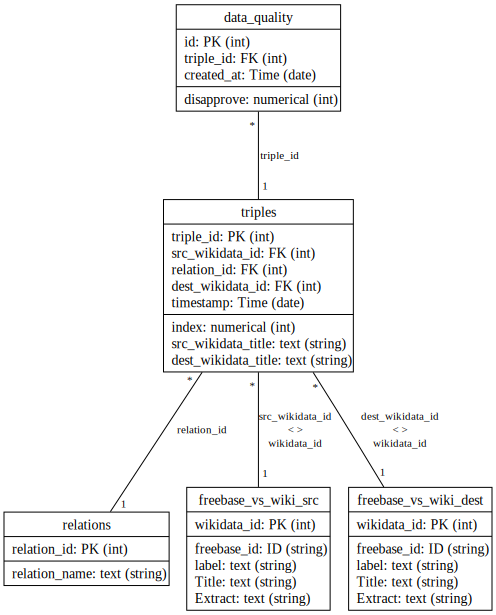

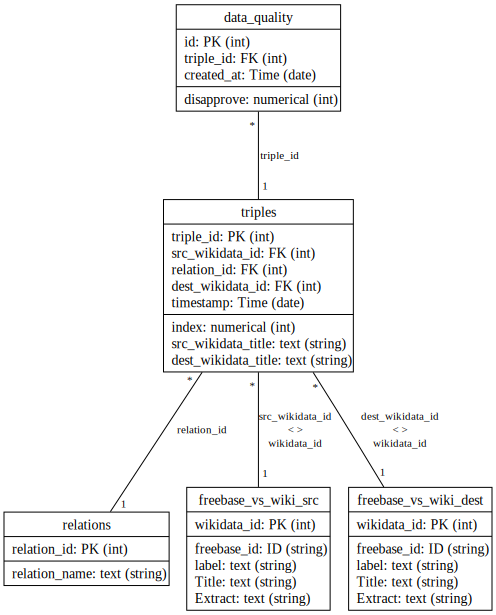

In [161]:
graph.visualize()

In [162]:
# graph['triples']['relation'].stype
# graph['triples']['relation_id'].stype

In [166]:
model = rfm.KumoRFM(graph)

Output()

In [164]:
# PREDICT triples.relation
# Couldn't pick a unique triples.relation for each freebase_vs_wiki. row 1, column 8: Encountered an error, we have found 
# multiple 'relation' values in the 'triples' table for a single 'freebase_vs_wiki'. To fix this, you have two options:
## 1. Aggregate the values: If your 'triples' table has a 'created at' column, use an aggregation function to reduce them to one value. 
##   For example: PREDICT LAST(triples.relation, 0, 30, days).
## 2. Rewrite your query: If you are writing a static node prediction predictive query, make sure that you 
##   either use the same table to define your target and entity, or you have a foreign key from the entity pointing to the target table, 
##   not the other way around.

# PREDICT triples.relation RANK TOP 10
## Problem type 'ProblemType.RANK' is only supported for multicategorical targets. . row 1, column 8: Target 'triples.relation' is 
## not multicategorical. Either drop the problem type ProblemType.RANK OR 
## change the target to a multicategorical column, 'LAST'/'FIRST' aggregation of a multicategorical column, or a 'LIST_DISTINCT' aggregation.

# FOR triples.src_wikidata_id=7413907
# Invalid entity. row 2, column 4: Entity 'triples.src_wikidata_id' is not a primary key. 
# The column used in 'FOR EACH' has to be a primary key.

# FOR 

# WHERE triples.relation contains 'place'


In [70]:
# kumo.init(api_key=KUMO_API_KEY)

In [71]:
# Working queries

query = """
PREDICT freebase_vs_wiki.freebase_id 
FOR freebase_vs_wiki.wikidata_id=7413907 
"""

query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki.wikidata_id=486860 
"""

# relations / types of edges for Arnold Schwarzenegger
query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685 
"""

query1 = """
PREDICT triples.inaccurate
FOR triples.triple_id =2685 
"""

# FOR triples.triple_id IN (1,2,3,4,168229,155507,15727) 

"""
PREDICT LIST_DISTINCT(triples.relation_id WHERE triples.inaccurate = 1, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685  
"""


'\nPREDICT LIST_DISTINCT(triples.relation_id WHERE triples.inaccurate = 1, 0, 80, days)\nFOR freebase_vs_wiki_src.wikidata_id=2685  \n'

In [72]:
# all triples associated with 2685
triple_ids_arnie=triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].triple_id.to_list()

In [73]:
triple_ids_arnie_str = f"{triple_ids_arnie}"
triple_ids_arnie_str = triple_ids_arnie_str.replace("[","(").replace("]",")")

In [74]:
query1 = """
PREDICT data_quality.disappove
FOR triples.triple_id IN """ + triple_ids_arnie_str

In [178]:
# triples with label 1 / inaccurate facts from test set
probe_triplet_ids_errors=df_test.loc[df_test['disapprove']==True].sample(100).triple_id.to_list()
probe_triplet_ids_non_errors=df_test.loc[df_test['disapprove']==False].sample(100).triple_id.to_list()

probe_triplet_ids_str = f"{probe_triplet_ids_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")

In [179]:
probe_triplet_ids_str = f"{probe_triplet_ids_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")
# print(probe_triplet_ids_str)

query1 = """
PREDICT AVG(data_quality.disapprove, 0, 80, days)
FOR triples.triple_id IN """ + probe_triplet_ids_str

pred_negatives_df = model.predict(query1)

probe_triplet_ids_str = f"{probe_triplet_ids_non_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")
query2 = """
PREDICT AVG(data_quality.disapprove, 0, 80, days)
FOR triples.triple_id IN """ + probe_triplet_ids_str

pred_positives_df = model.predict(query2)

/Users/ravid/miniconda3/envs/kumo-hackathon-py311/lib/python3.11/site-packages/kumoai/experimental/rfm/rfm.py:360: 
UserWarning: Anchor timestamp is too early or aggregation time range is too large. To form proper input data, we 
would need data back to '2024-08-24 00:00:00', however, your data only contains data back to '2024-10-04 00:00:00'.
  warnings.warn(f"Anchor timestamp is too early or aggregation "

Output()

/Users/ravid/miniconda3/envs/kumo-hackathon-py311/lib/python3.11/site-packages/kumoai/experimental/rfm/rfm.py:360: 
UserWarning: Anchor timestamp is too early or aggregation time range is too large. To form proper input data, we 
would need data back to '2024-08-24 00:00:00', however, your data only contains data back to '2024-10-04 00:00:00'.
  warnings.warn(f"Anchor timestamp is too early or aggregation "

Output()

In [42]:
# display(pred1_df)
# pred1_df.describe()

In [180]:
print(pred_positives_df.TARGET_PRED.describe())

print(pred_negatives_df.TARGET_PRED.describe())

count    100.000000
mean       0.000132
std        0.000107
min        0.000000
25%        0.000050
50%        0.000095
75%        0.000232
max        0.000421
Name: TARGET_PRED, dtype: float64
count    100.000000
mean       0.000162
std        0.000136
min        0.000000
25%        0.000050
50%        0.000100
75%        0.000312
max        0.000413
Name: TARGET_PRED, dtype: float64


In [186]:
# plot(pred1_df.TARGET_PRED)

<Axes: xlabel='TARGET_PRED', ylabel='Probability'>

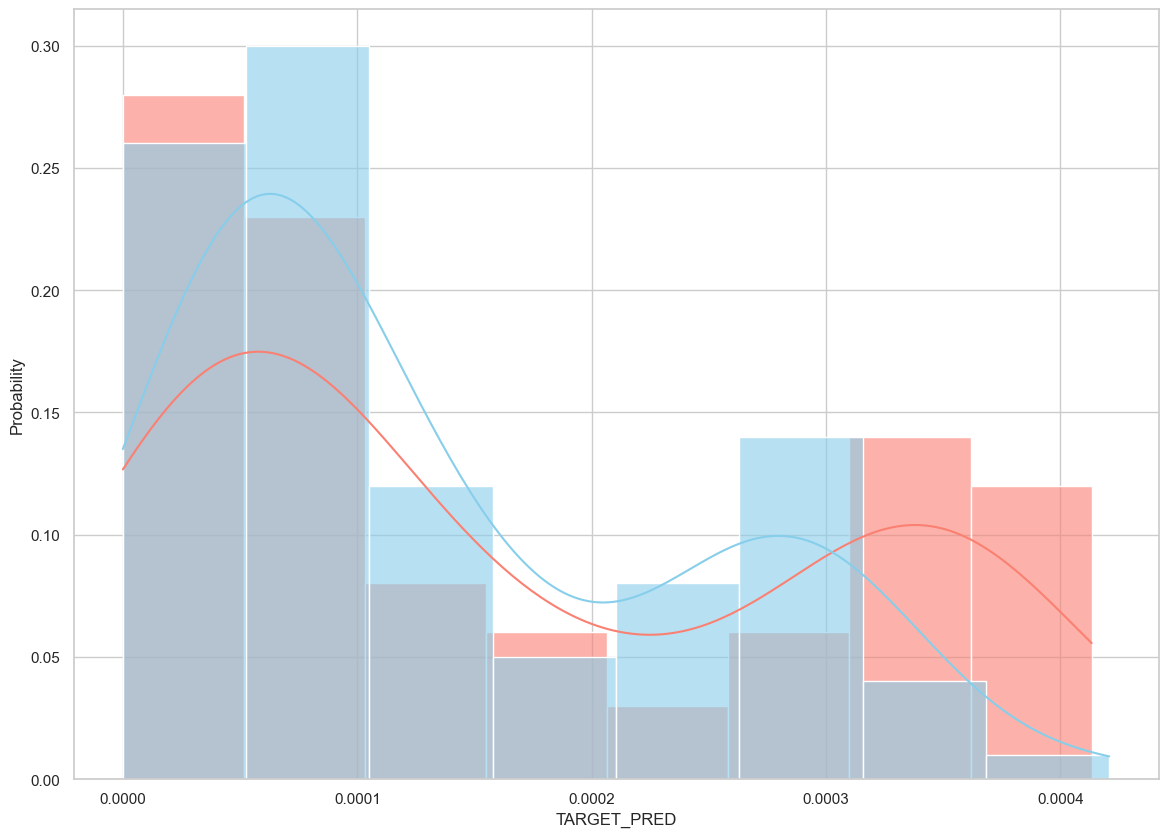

In [183]:
# plot distribution of target_pred

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))

sns.histplot(
    data=pred_negatives_df, 
    x='TARGET_PRED', 
    bins=8, 
    kde=True, 
    color='salmon', 
    alpha=0.6, 
    stat='probability',
    label='Score (Outliers)',
)

sns.histplot(
    data=pred_positives_df, 
    x='TARGET_PRED', 
    bins=8, 
    kde=True, 
    color='skyblue', 
    alpha=0.6, 
    stat='probability',
    label='Score (Baseline)',
)


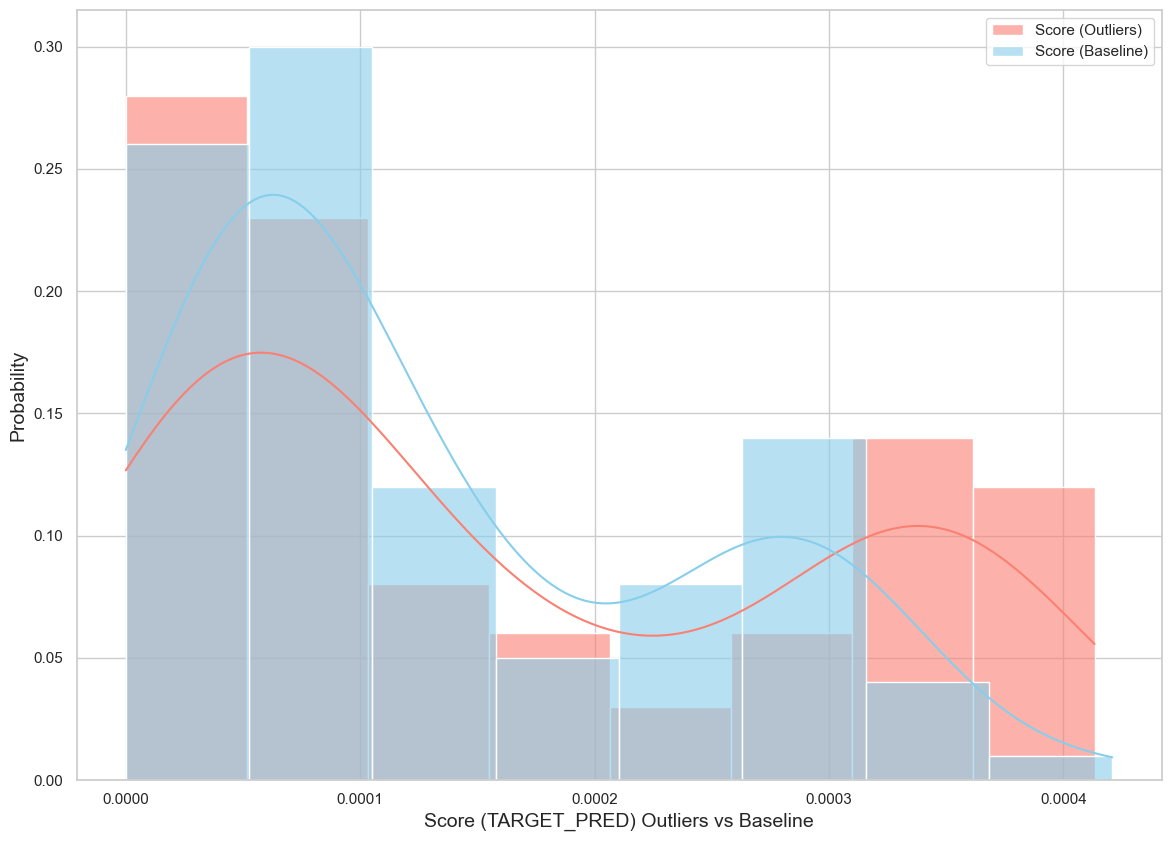

In [186]:
# plot distribution of target_pred

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 10))

sns.histplot(
    data=pred_negatives_df, 
    x='TARGET_PRED', 
    bins=8, 
    kde=True, 
    color='salmon', 
    alpha=0.6, 
    stat='probability',
    label='Score (Outliers)',
    ax=ax,
)

sns.histplot(
    data=pred_positives_df, 
    x='TARGET_PRED', 
    bins=8, 
    kde=True, 
    color='skyblue', 
    alpha=0.6, 
    stat='probability',
    label='Score (Baseline)',
    ax=ax,
)

ax.set_xlabel('Score (TARGET_PRED) Outliers vs Baseline', fontsize=14)
ax.set_ylabel('Probability', fontsize=14)
ax.legend()

plt.show()

In [174]:
# pred1_df.loc[pred1_df['PREDICTED']==False].sort_values(by='SCORE', ascending=False)
pred1_df.sort_values(by='TARGET_PRED', ascending=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED
1,272117,1738281600000,0.131647
24,272146,1738281600000,0.128768
16,272135,1738281600000,0.126386
12,272129,1738281600000,0.122993
6,272122,1738281600000,0.121498
28,272153,1738281600000,0.120701
7,272123,1738281600000,0.120521
26,272149,1738281600000,0.119449
29,272155,1738281600000,0.119343
25,272148,1738281600000,0.116192


In [45]:
df_test.loc[df_test['disapprove']==False].head()

,src_freebase_id,relation,dest_freebase_id,timestamp,relation_name,relation_id,freebase_id_x,label_x,src_wikidata_id,freebase_id_y,label_y,dest_wikidata_id,triple_id,disapprove
0,/m/02jx1,/location/location/contains,/m/013t85,2025-01-02,/location/location/contains,15,/m/02jx1,England,21,/m/013t85,Pontefract,1009235,272118,False
1,/m/05zrvfd,/award/award_category/nominees./award/award_no...,/m/04y9mm8,2025-01-02,/award/award_category/nominees./award/award_no...,7,/m/05zrvfd,MTV Movie Award for Best Scared-As-S**t Perfor...,425675,/m/04y9mm8,Piranha 3D,733995,272121,False
2,/m/07l450,/film/film/genre,/m/082gq,2025-01-02,/film/film/genre,31,/m/07l450,The Last King of Scotland,176826,/m/082gq,war film,369747,272123,False
3,/m/07h1h5,/sports/pro_athlete/teams./sports/sports_team_...,/m/029q3k,2025-01-02,/sports/pro_athlete/teams./sports/sports_team_...,40,/m/07h1h5,Kasper Schmeichel,295797,/m/029q3k,Notts County F.C.,19598,272124,False
4,/m/0kbws,/olympics/olympic_games/participating_countries,/m/027jk,2025-01-02,/olympics/olympic_games/participating_countries,157,/m/0kbws,2008 Summer Olympics,8567,/m/027jk,Djibouti,977,272133,False


pquery_relations_for_entity = kumo.PredictiveQuery(
	graph=graph,
	query=query
)

pquery_relations_for_entity.validate()

In [273]:
graph._to_api_graph_definition()

GraphDefinition(tables={'triples': TableDefinition(cols=[Column(name='triple_id', stype=ID, dtype=int, timestamp_format=None), Column(name='src_wikidata_id', stype=ID, dtype=int, timestamp_format=None), Column(name='relation_id', stype=ID, dtype=int, timestamp_format=None), Column(name='dest_wikidata_id', stype=ID, dtype=int, timestamp_format=None), Column(name='timestamp', stype=timestamp, dtype=string, timestamp_format=None), Column(name='inaccurate', stype=categorical, dtype=int, timestamp_format=None)], source_table=UnavailableSourceTable(table='triples', data_source_type=UNAVAILABLE), pkey='triple_id', time_col='timestamp', end_time_col=None), 'relations': TableDefinition(cols=[Column(name='relation_name', stype=text, dtype=string, timestamp_format=None), Column(name='relation_id', stype=ID, dtype=int, timestamp_format=None)], source_table=UnavailableSourceTable(table='relations', data_source_type=UNAVAILABLE), pkey='relation_id', time_col=None, end_time_col=None), 'freebase_vs_wi

In [ ]:
# Running examples
# all relations with src_wikidata_id 
## 7413907 / Q7413907 , San Francisco
## 486860 , Mountain View
## 2685, Arnold Schwarzenegger


triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].to_csv(
    "~/Downloads/arnold_schwarzenegger_outgoing_edges.csv", index=False
)


In [ ]:
## Arnold Schwarznegger

# 6 -> /film/actor/film./film/performance/film
# 38 -> nomination
# 

## Yago semantic graph 
Usecase - find inconsistencies / anomalies in knowledge graphs